In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from pyrl.agents.classic import QLearning as ClassicQLearning
from pyrl.agents.survival import QLearning as SurvivalQLearning
from pyrl.agents.survival import KLearning
from pyrl.environments.survival import SurvivalEnv
from pyrl import Sim, Agent, Env, EnvWrapper, System

from pyrl.environments.grid import GridEnv, GridEnvGUI

from gymnasium.spaces import Discrete, MultiDiscrete

In [25]:
#ENVIRONMENT PARAMETERS

num_cols = 50
num_rows = 5
map_size = (num_cols, num_rows)

minor_r=5
major_r=50
step_r=-1

horizon = 2000

gamma = 0.95 #discount factor

reward_targets = {major_r : [(num_cols - 2, num_rows // 2)],
                  minor_r : [(3*(num_cols - 1) // 5, num_rows // 2), ((num_cols - 1) // 3, num_rows // 2)]}


## Test with rendering

In the next cell, we call a single simulation with visual rendering.

Use `skip_visual_test` to enable or disable it.

In [53]:
skip_visual_test = False

if skip_visual_test:
    
    print("Skipping visual test")
    
else:
    
    env = GridEnv(num_rows=num_rows, num_cols=num_cols, 
                  reward_mode="s'", reward_targets=reward_targets, default_reward=-1.0,
                  render_mode="external")

    initial_budget = 500
    
    initial_Q_value = 0
    initial_K_value = 200
    survival_threshold = 250
    exploration_threshold = 500
    alpha = 0.5 #learning rate

    agent_K = KLearning(
        env.observation_space,
        env.action_space,
        initial_budget=initial_budget,
        should_explore=None,
        discount=gamma,
        learning_rate=alpha,
        initial_Q_value=initial_Q_value,
        initial_K_value=initial_K_value,
        survival_threshold=survival_threshold,
        exploration_threshold=exploration_threshold,
    )

    epsilon=0.5 #exploration rate
    
    agent_Q = ClassicQLearning(env.observation_space, 
                             env.action_space, 
                             initial_budget=initial_budget, 
                             discount=gamma,
                             learning_rate=alpha,
                             exploration_rate=epsilon,
                             initial_Q_value=initial_Q_value)

    sim = Sim([agent_Q, agent_K], env, episode_horizon=horizon)
    
    
    gui = GridEnvGUI(sim, cell_size=35, fps=50, close_on_finish=True)

    gui.launch(give_first_step=True, start_running=True)

    

## Massive Tests

In [38]:
horizon = 5000

initial_Q_value = 0
initial_K_value = 200

alpha = 0.5 #learning rate

repeat = 50

budgets = np.array([100, 200, 300, 400, 500, 600, 700, 800])

reward_targets = {major_r : [(num_cols - 2, num_rows // 2)],
                  minor_r : [(3*(num_cols - 1) // 5, num_rows // 2), ((num_cols - 1) // 3, num_rows // 2)]}

env = GridEnv(num_rows=num_rows, num_cols=num_cols, 
              reward_mode="s'", reward_targets=reward_targets, default_reward=-1.0,
              render_mode="external")



In [39]:
def simulation_started_callback(sim):
    #print("START SIM")
    #print(sim.env.observation_shape)
    #print(sim.env.action_shape)
    #print(sim.env.observation_shape + env.action_shape)
    sim.metrics = dict(
        time = 0,
        exploration = np.zeros(sim.env.observation_shape + sim.env.action_shape),
        budget = np.zeros((sim.episode_horizon,), dtype=int)
    )

def simulation_finished_callback(sim):
    print("END SIM")

def episode_started_callback(sim):
    print("START EPISODE")

def episode_finished_callback(sim):
    print("END EPISODE")
    #pass

def round_started_callback(sim):
    #print("START ROUND")
    pass

def round_finished_callback(sim):
    #print("END ROUND")
    sim.metrics["time"] = sim.metrics["time"] + 1
    state_action_index = tuple(np.concatenate( (sim.agent.get_state(), sim.agent.get_action()) ) )
    v = sim.metrics["exploration"].item(state_action_index)
    sim.metrics["exploration"].itemset(state_action_index, v+1)
    sim.metrics["budget"][sim.t-1] = agent.budget

## Classic QLearning $\varepsilon = 0.1$

In [40]:
qclassic_time_mean = np.full(budgets.shape, -1)
qclassic_exploration_rate = np.full(budgets.shape, -1)
qclassic_alive_rate = np.full(budgets.shape, -1)
qclassic_budget_evolutions_mean = np.full(budgets.shape, None)
qclassic_budget_evolutions_max = np.full(budgets.shape, None)
qclassic_budget_evolutions_min = np.full(budgets.shape, None)
qclassic_exploration_map = np.full(budgets.shape, None)

epsilon=0.1

print("====> Classic QLearning")

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"b={b}", end=" ")
    for j in range(repeat):
        print(f"{j+1}", end=" ")
        agent = ClassicQLearning(env.observation_space, 
                                 env.action_space, 
                                 initial_budget=b, 
                                 discount=gamma,
                                 learning_rate=alpha,
                                 exploration_rate=epsilon,
                                 initial_Q_value=initial_Q_value)
        sim = Sim(agent, env, episode_horizon=horizon)
        sim.add_listener('simulation_started', simulation_started_callback)
        sim.add_listener('round_finished', round_finished_callback)
        sim.run()

        if qclassic_time_mean[i] == -1:
            qclassic_time_mean[i] = sim.metrics["time"]
        else:
            qclassic_time_mean[i] = qclassic_time_mean[i] + (1/j) * (sim.metrics["time"] - qclassic_time_mean[i])
        
        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.num_obs_comb * env.num_act_comb)) * 100

        if qclassic_exploration_rate[i] == -1:
            qclassic_exploration_rate[i] = exploration_rate
        else:
            qclassic_exploration_rate[i] = qclassic_exploration_rate[i] + (1 / j) * (exploration_rate - qclassic_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        qclassic_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if qclassic_budget_evolutions_mean[i] is None:
            qclassic_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_mean[i] = qclassic_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - qclassic_budget_evolutions_mean[i])

        # budget evolution max
        if qclassic_budget_evolutions_max[i] is None:
            qclassic_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_max[i] = np.maximum(qclassic_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if qclassic_budget_evolutions_min[i] is None:
            qclassic_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_min[i] = np.minimum(qclassic_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if qclassic_exploration_map[i] is None:
            qclassic_exploration_map[i] = sim.metrics["exploration"]
        else:
            qclassic_exploration_map[i] = qclassic_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - qclassic_exploration_map[i])

    print()
    print(f"Time mean : {qclassic_time_mean[i]}")
    print(f"Alive rate : {qclassic_alive_rate[i]}%")


qclassic_1_time_mean = qclassic_time_mean
qclassic_1_exploration_rate = qclassic_exploration_rate
qclassic_1_alive_rate = qclassic_alive_rate
qclassic_1_budget_evolutions_mean = qclassic_budget_evolutions_mean
qclassic_1_budget_evolutions_max = qclassic_budget_evolutions_max
qclassic_1_budget_evolutions_min = qclassic_budget_evolutions_min
qclassic_1_exploration_map = qclassic_exploration_map

====> Classic QLearning
b=100 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 100
Alive rate : 0%
b=200 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 296
Alive rate : 2%
b=300 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 1270
Alive rate : 20%
b=400 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 1900
Alive rate : 34%
b=500 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 3621
Alive rate : 68%
b=600 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 2

## Classic QLearning $\varepsilon = 0.3$

In [41]:
qclassic_time_mean = np.full(budgets.shape, -1)
qclassic_exploration_rate = np.full(budgets.shape, -1)
qclassic_alive_rate = np.full(budgets.shape, -1)
qclassic_budget_evolutions_mean = np.full(budgets.shape, None)
qclassic_budget_evolutions_max = np.full(budgets.shape, None)
qclassic_budget_evolutions_min = np.full(budgets.shape, None)
qclassic_exploration_map = np.full(budgets.shape, None)

epsilon=0.3

print("====> Classic QLearning")

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"b={b}", end=" ")
    for j in range(repeat):
        print(f"{j+1}", end=" ")
        agent = ClassicQLearning(env.observation_space, 
                                 env.action_space, 
                                 initial_budget=b, 
                                 discount=gamma,
                                 learning_rate=alpha,
                                 exploration_rate=epsilon,
                                 initial_Q_value=initial_Q_value)
        sim = Sim(agent, env, episode_horizon=horizon)
        sim.add_listener('simulation_started', simulation_started_callback)
        sim.add_listener('round_finished', round_finished_callback)
        sim.run()

        if qclassic_time_mean[i] == -1:
            qclassic_time_mean[i] = sim.metrics["time"]
        else:
            qclassic_time_mean[i] = qclassic_time_mean[i] + (1/j) * (sim.metrics["time"] - qclassic_time_mean[i])
        
        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.num_obs_comb * env.num_act_comb)) * 100

        if qclassic_exploration_rate[i] == -1:
            qclassic_exploration_rate[i] = exploration_rate
        else:
            qclassic_exploration_rate[i] = qclassic_exploration_rate[i] + (1 / j) * (exploration_rate - qclassic_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        qclassic_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if qclassic_budget_evolutions_mean[i] is None:
            qclassic_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_mean[i] = qclassic_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - qclassic_budget_evolutions_mean[i])

        # budget evolution max
        if qclassic_budget_evolutions_max[i] is None:
            qclassic_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_max[i] = np.maximum(qclassic_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if qclassic_budget_evolutions_min[i] is None:
            qclassic_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_min[i] = np.minimum(qclassic_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if qclassic_exploration_map[i] is None:
            qclassic_exploration_map[i] = sim.metrics["exploration"]
        else:
            qclassic_exploration_map[i] = qclassic_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - qclassic_exploration_map[i])

    print()
    print(f"Time mean : {qclassic_time_mean[i]}")
    print(f"Alive rate : {qclassic_alive_rate[i]}%")


qclassic_3_time_mean = qclassic_time_mean
qclassic_3_exploration_rate = qclassic_exploration_rate
qclassic_3_alive_rate = qclassic_alive_rate
qclassic_3_budget_evolutions_mean = qclassic_budget_evolutions_mean
qclassic_3_budget_evolutions_max = qclassic_budget_evolutions_max
qclassic_3_budget_evolutions_min = qclassic_budget_evolutions_min
qclassic_3_exploration_map = qclassic_exploration_map

====> Classic QLearning
b=100 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 100
Alive rate : 0%
b=200 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 210
Alive rate : 0%
b=300 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 722
Alive rate : 8%
b=400 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 718
Alive rate : 6%
b=500 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 2435
Alive rate : 44%
b=600 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26

## Classic QLearning $\varepsilon = 0.5$

In [42]:
qclassic_time_mean = np.full(budgets.shape, -1)
qclassic_exploration_rate = np.full(budgets.shape, -1)
qclassic_alive_rate = np.full(budgets.shape, -1)
qclassic_budget_evolutions_mean = np.full(budgets.shape, None)
qclassic_budget_evolutions_max = np.full(budgets.shape, None)
qclassic_budget_evolutions_min = np.full(budgets.shape, None)
qclassic_exploration_map = np.full(budgets.shape, None)

epsilon=0.3

print("====> Classic QLearning")

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"b={b}", end=" ")
    for j in range(repeat):
        print(f"{j+1}", end=" ")
        agent = ClassicQLearning(env.observation_space, 
                                 env.action_space, 
                                 initial_budget=b, 
                                 discount=gamma,
                                 learning_rate=alpha,
                                 exploration_rate=epsilon,
                                 initial_Q_value=initial_Q_value)
        sim = Sim(agent, env, episode_horizon=horizon)
        sim.add_listener('simulation_started', simulation_started_callback)
        sim.add_listener('round_finished', round_finished_callback)
        sim.run()

        if qclassic_time_mean[i] == -1:
            qclassic_time_mean[i] = sim.metrics["time"]
        else:
            qclassic_time_mean[i] = qclassic_time_mean[i] + (1/j) * (sim.metrics["time"] - qclassic_time_mean[i])
        
        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.num_obs_comb * env.num_act_comb)) * 100

        if qclassic_exploration_rate[i] == -1:
            qclassic_exploration_rate[i] = exploration_rate
        else:
            qclassic_exploration_rate[i] = qclassic_exploration_rate[i] + (1 / j) * (exploration_rate - qclassic_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        qclassic_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if qclassic_budget_evolutions_mean[i] is None:
            qclassic_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_mean[i] = qclassic_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - qclassic_budget_evolutions_mean[i])

        # budget evolution max
        if qclassic_budget_evolutions_max[i] is None:
            qclassic_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_max[i] = np.maximum(qclassic_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if qclassic_budget_evolutions_min[i] is None:
            qclassic_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_min[i] = np.minimum(qclassic_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if qclassic_exploration_map[i] is None:
            qclassic_exploration_map[i] = sim.metrics["exploration"]
        else:
            qclassic_exploration_map[i] = qclassic_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - qclassic_exploration_map[i])

    print()
    print(f"Time mean : {qclassic_time_mean[i]}")
    print(f"Alive rate : {qclassic_alive_rate[i]}%")


qclassic_5_time_mean = qclassic_time_mean
qclassic_5_exploration_rate = qclassic_exploration_rate
qclassic_5_alive_rate = qclassic_alive_rate
qclassic_5_budget_evolutions_mean = qclassic_budget_evolutions_mean
qclassic_5_budget_evolutions_max = qclassic_budget_evolutions_max
qclassic_5_budget_evolutions_min = qclassic_budget_evolutions_min
qclassic_5_exploration_map = qclassic_exploration_map

====> Classic QLearning
b=100 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 114
Alive rate : 0%
b=200 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 211
Alive rate : 0%
b=300 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 922
Alive rate : 12%
b=400 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 1357
Alive rate : 20%
b=500 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 1994
Alive rate : 34%
b=600 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25

## Classic QLearning greedy

In [43]:
qclassic_time_mean = np.full(budgets.shape, -1)
qclassic_exploration_rate = np.full(budgets.shape, -1)
qclassic_alive_rate = np.full(budgets.shape, -1)
qclassic_budget_evolutions_mean = np.full(budgets.shape, None)
qclassic_budget_evolutions_max = np.full(budgets.shape, None)
qclassic_budget_evolutions_min = np.full(budgets.shape, None)
qclassic_exploration_map = np.full(budgets.shape, None)

epsilon=0.0

print("====> Classic QLearning")

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"b={b}", end=" ")
    for j in range(repeat):
        print(f"{j+1}", end=" ")
        agent = ClassicQLearning(env.observation_space, 
                                 env.action_space, 
                                 initial_budget=b, 
                                 discount=gamma,
                                 learning_rate=alpha,
                                 exploration_rate=epsilon,
                                 initial_Q_value=initial_Q_value)
        sim = Sim(agent, env, episode_horizon=horizon)
        sim.add_listener('simulation_started', simulation_started_callback)
        sim.add_listener('round_finished', round_finished_callback)
        sim.run()

        if qclassic_time_mean[i] == -1:
            qclassic_time_mean[i] = sim.metrics["time"]
        else:
            qclassic_time_mean[i] = qclassic_time_mean[i] + (1/j) * (sim.metrics["time"] - qclassic_time_mean[i])
        
        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.num_obs_comb * env.num_act_comb)) * 100

        if qclassic_exploration_rate[i] == -1:
            qclassic_exploration_rate[i] = exploration_rate
        else:
            qclassic_exploration_rate[i] = qclassic_exploration_rate[i] + (1 / j) * (exploration_rate - qclassic_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        qclassic_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if qclassic_budget_evolutions_mean[i] is None:
            qclassic_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_mean[i] = qclassic_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - qclassic_budget_evolutions_mean[i])

        # budget evolution max
        if qclassic_budget_evolutions_max[i] is None:
            qclassic_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_max[i] = np.maximum(qclassic_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if qclassic_budget_evolutions_min[i] is None:
            qclassic_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_min[i] = np.minimum(qclassic_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if qclassic_exploration_map[i] is None:
            qclassic_exploration_map[i] = sim.metrics["exploration"]
        else:
            qclassic_exploration_map[i] = qclassic_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - qclassic_exploration_map[i])

    print()
    print(f"Time mean : {qclassic_time_mean[i]}")
    print(f"Alive rate : {qclassic_alive_rate[i]}%")


qclassic_0_time_mean = qclassic_time_mean
qclassic_0_exploration_rate = qclassic_exploration_rate
qclassic_0_alive_rate = qclassic_alive_rate
qclassic_0_budget_evolutions_mean = qclassic_budget_evolutions_mean
qclassic_0_budget_evolutions_max = qclassic_budget_evolutions_max
qclassic_0_budget_evolutions_min = qclassic_budget_evolutions_min
qclassic_0_exploration_map = qclassic_exploration_map

====> Classic QLearning
b=100 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 100
Alive rate : 0%
b=200 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 200
Alive rate : 0%
b=300 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 1058
Alive rate : 18%
b=400 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 2080
Alive rate : 36%
b=500 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 3335
Alive rate : 64%
b=600 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 2

## Classic Q-Learning optimistic

In [44]:
qclassic_time_mean = np.full(budgets.shape, -1)
qclassic_exploration_rate = np.full(budgets.shape, -1)
qclassic_alive_rate = np.full(budgets.shape, -1)
qclassic_budget_evolutions_mean = np.full(budgets.shape, None)
qclassic_budget_evolutions_max = np.full(budgets.shape, None)
qclassic_budget_evolutions_min = np.full(budgets.shape, None)
qclassic_exploration_map = np.full(budgets.shape, None)

epsilon=0.0

print("====> Classic QLearning")

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"b={b}", end=" ")
    for j in range(repeat):
        print(f"{j+1}", end=" ")
        agent = ClassicQLearning(env.observation_space, 
                                 env.action_space, 
                                 initial_budget=b, 
                                 discount=gamma,
                                 learning_rate=alpha,
                                 exploration_rate=epsilon,
                                 initial_Q_value=initial_K_value)
        sim = Sim(agent, env, episode_horizon=horizon)
        sim.add_listener('simulation_started', simulation_started_callback)
        sim.add_listener('round_finished', round_finished_callback)
        sim.run()

        if qclassic_time_mean[i] == -1:
            qclassic_time_mean[i] = sim.metrics["time"]
        else:
            qclassic_time_mean[i] = qclassic_time_mean[i] + (1/j) * (sim.metrics["time"] - qclassic_time_mean[i])
        
        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.num_obs_comb * env.num_act_comb)) * 100

        if qclassic_exploration_rate[i] == -1:
            qclassic_exploration_rate[i] = exploration_rate
        else:
            qclassic_exploration_rate[i] = qclassic_exploration_rate[i] + (1 / j) * (exploration_rate - qclassic_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        qclassic_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if qclassic_budget_evolutions_mean[i] is None:
            qclassic_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_mean[i] = qclassic_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - qclassic_budget_evolutions_mean[i])

        # budget evolution max
        if qclassic_budget_evolutions_max[i] is None:
            qclassic_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_max[i] = np.maximum(qclassic_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if qclassic_budget_evolutions_min[i] is None:
            qclassic_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_min[i] = np.minimum(qclassic_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if qclassic_exploration_map[i] is None:
            qclassic_exploration_map[i] = sim.metrics["exploration"]
        else:
            qclassic_exploration_map[i] = qclassic_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - qclassic_exploration_map[i])

    print()
    print(f"Time mean : {qclassic_time_mean[i]}")
    print(f"Alive rate : {qclassic_alive_rate[i]}%")


qclassic_h_time_mean = qclassic_time_mean
qclassic_h_exploration_rate = qclassic_exploration_rate
qclassic_h_alive_rate = qclassic_alive_rate
qclassic_h_budget_evolutions_mean = qclassic_budget_evolutions_mean
qclassic_h_budget_evolutions_max = qclassic_budget_evolutions_max
qclassic_h_budget_evolutions_min = qclassic_budget_evolutions_min
qclassic_h_exploration_map = qclassic_exploration_map

====> Classic QLearning
b=100 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 100
Alive rate : 0%
b=200 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 200
Alive rate : 0%
b=300 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 300
Alive rate : 0%
b=400 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 400
Alive rate : 0%
b=500 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 504
Alive rate : 0%
b=600 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 2

## Survival QLearning $w = \{250 - 500\}$

In [45]:
qsurvival_time_mean = np.full(budgets.shape, -1)
qsurvival_exploration_rate = np.full(budgets.shape, -1)
qsurvival_alive_rate = np.full(budgets.shape, -1)
qsurvival_budget_evolutions_mean = np.full(budgets.shape, None)
qsurvival_budget_evolutions_max = np.full(budgets.shape, None)
qsurvival_budget_evolutions_min = np.full(budgets.shape, None)
qsurvival_exploration_map = np.full(budgets.shape, None)

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"b={b}", end=" ")
    for j in range(repeat):
        print(f"{j+1}", end=" ")
        #print(f"====> Survival QLearning {b} | Try {j + 1}")
        #agent = SurvivalQLearning(env.observation_space, env.action_space, survival_threshold=survival_threshold, budget=b, should_explore=should_explore, discount=gamma)
        agent = KLearning(
            env.observation_space,
            env.action_space,
            initial_budget=b,
            discount=gamma,
            learning_rate=alpha,
            initial_Q_value=initial_Q_value,
            initial_K_value=initial_K_value,
            survival_threshold=250,
            exploration_threshold=500,
        )
        sim = Sim(agent, env, episode_horizon=horizon)
        sim.add_listener('simulation_started', simulation_started_callback)
        sim.add_listener('round_finished', round_finished_callback)
        sim.run()

        if qsurvival_time_mean[i] == -1:
            qsurvival_time_mean[i] = sim.metrics["time"]
        else:
            qsurvival_time_mean[i] = qsurvival_time_mean[i] + (1/j) * (sim.metrics["time"] - qsurvival_time_mean[i])

        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.num_obs_comb * env.num_act_comb)) * 100

        if qsurvival_exploration_rate[i] == -1:
            qsurvival_exploration_rate[i] = exploration_rate
        else:
            qsurvival_exploration_rate[i] = qsurvival_exploration_rate[i] + (1 / j) * (exploration_rate - qsurvival_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        qsurvival_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if qsurvival_budget_evolutions_mean[i] is None:
            qsurvival_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            qsurvival_budget_evolutions_mean[i] = qsurvival_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - qsurvival_budget_evolutions_mean[i])

        # budget evolution max
        if qsurvival_budget_evolutions_max[i] is None:
            qsurvival_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            qsurvival_budget_evolutions_max[i] = np.maximum(qsurvival_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if qsurvival_budget_evolutions_min[i] is None:
            qsurvival_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            qsurvival_budget_evolutions_min[i] = np.minimum(qsurvival_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if qsurvival_exploration_map[i] is None:
            qsurvival_exploration_map[i] = sim.metrics["exploration"]
        else:
            qsurvival_exploration_map[i] = qsurvival_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - qsurvival_exploration_map[i])

        #print(f"Time mean : {qsurvival_time_mean[i]}")
        #print(f"Alive rate : {qsurvival_alive_rate[i]}%")
        
    print()
    print(f"* average survival time : {qsurvival_time_mean[i]}")
    print(f"* alive rate : {qsurvival_alive_rate[i]}%")
    
qsurvival_250_time_mean = qsurvival_time_mean
qsurvival_250_exploration_rate = qsurvival_exploration_rate
qsurvival_250_alive_rate = qsurvival_alive_rate
qsurvival_250_budget_evolutions_mean = qsurvival_budget_evolutions_mean
qsurvival_250_budget_evolutions_max = qsurvival_budget_evolutions_max
qsurvival_250_budget_evolutions_min = qsurvival_budget_evolutions_min
qsurvival_250_exploration_map = qsurvival_exploration_map
        

b=100 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
* average survival time : 100
* alive rate : 0%
b=200 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
* average survival time : 384
* alive rate : 4%
b=300 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
* average survival time : 548
* alive rate : 2%
b=400 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
* average survival time : 1973
* alive rate : 22%
b=500 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
* average survival time : 2051
* alive rate : 28%
b=600 1 2 3 4 5 

## Survival QLearning $w = \{400, 800\}$

In [46]:
qsurvival_time_mean = np.full(budgets.shape, -1)
qsurvival_exploration_rate = np.full(budgets.shape, -1)
qsurvival_alive_rate = np.full(budgets.shape, -1)
qsurvival_budget_evolutions_mean = np.full(budgets.shape, None)
qsurvival_budget_evolutions_max = np.full(budgets.shape, None)
qsurvival_budget_evolutions_min = np.full(budgets.shape, None)
qsurvival_exploration_map = np.full(budgets.shape, None)

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"b={b}", end=" ")
    for j in range(repeat):
        print(f"{j+1}", end=" ")
        #print(f"====> Survival QLearning {b} | Try {j + 1}")
        #agent = SurvivalQLearning(env.observation_space, env.action_space, survival_threshold=survival_threshold, budget=b, should_explore=should_explore, discount=gamma)
        agent = KLearning(
            env.observation_space,
            env.action_space,
            initial_budget=b,
            discount=gamma,
            learning_rate=alpha,
            initial_Q_value=initial_Q_value,
            initial_K_value=initial_K_value,
            survival_threshold=400,
            exploration_threshold=800,
        )
        sim = Sim(agent, env, episode_horizon=horizon)
        sim.add_listener('simulation_started', simulation_started_callback)
        sim.add_listener('round_finished', round_finished_callback)
        sim.run()

        if qsurvival_time_mean[i] == -1:
            qsurvival_time_mean[i] = sim.metrics["time"]
        else:
            qsurvival_time_mean[i] = qsurvival_time_mean[i] + (1/j) * (sim.metrics["time"] - qsurvival_time_mean[i])

        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.num_obs_comb * env.num_act_comb)) * 100

        if qsurvival_exploration_rate[i] == -1:
            qsurvival_exploration_rate[i] = exploration_rate
        else:
            qsurvival_exploration_rate[i] = qsurvival_exploration_rate[i] + (1 / j) * (exploration_rate - qsurvival_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        qsurvival_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if qsurvival_budget_evolutions_mean[i] is None:
            qsurvival_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            qsurvival_budget_evolutions_mean[i] = qsurvival_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - qsurvival_budget_evolutions_mean[i])

        # budget evolution max
        if qsurvival_budget_evolutions_max[i] is None:
            qsurvival_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            qsurvival_budget_evolutions_max[i] = np.maximum(qsurvival_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if qsurvival_budget_evolutions_min[i] is None:
            qsurvival_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            qsurvival_budget_evolutions_min[i] = np.minimum(qsurvival_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if qsurvival_exploration_map[i] is None:
            qsurvival_exploration_map[i] = sim.metrics["exploration"]
        else:
            qsurvival_exploration_map[i] = qsurvival_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - qsurvival_exploration_map[i])

        #print(f"Time mean : {qsurvival_time_mean[i]}")
        #print(f"Alive rate : {qsurvival_alive_rate[i]}%")
        
    print()
    print(f"* average survival time : {qsurvival_time_mean[i]}")
    print(f"* alive rate : {qsurvival_alive_rate[i]}%")
    
qsurvival_400_time_mean = qsurvival_time_mean
qsurvival_400_exploration_rate = qsurvival_exploration_rate
qsurvival_400_alive_rate = qsurvival_alive_rate
qsurvival_400_budget_evolutions_mean = qsurvival_budget_evolutions_mean
qsurvival_400_budget_evolutions_max = qsurvival_budget_evolutions_max
qsurvival_400_budget_evolutions_min = qsurvival_budget_evolutions_min
qsurvival_400_exploration_map = qsurvival_exploration_map

b=100 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
* average survival time : 100
* alive rate : 0%
b=200 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
* average survival time : 482
* alive rate : 6%
b=300 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
* average survival time : 1250
* alive rate : 20%
b=400 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
* average survival time : 2001
* alive rate : 36%
b=500 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
* average survival time : 2732
* alive rate : 46%
b=600 1 2 3 4 

## Survival QLearning $w=\{600 - 1000\}$

In [47]:
qsurvival_time_mean = np.full(budgets.shape, -1)
qsurvival_exploration_rate = np.full(budgets.shape, -1)
qsurvival_alive_rate = np.full(budgets.shape, -1)
qsurvival_budget_evolutions_mean = np.full(budgets.shape, None)
qsurvival_budget_evolutions_max = np.full(budgets.shape, None)
qsurvival_budget_evolutions_min = np.full(budgets.shape, None)
qsurvival_exploration_map = np.full(budgets.shape, None)

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"b={b}", end=" ")
    for j in range(repeat):
        print(f"{j+1}", end=" ")
        #print(f"====> Survival QLearning {b} | Try {j + 1}")
        #agent = SurvivalQLearning(env.observation_space, env.action_space, survival_threshold=survival_threshold, budget=b, should_explore=should_explore, discount=gamma)
        agent = KLearning(
            env.observation_space,
            env.action_space,
            initial_budget=b,
            discount=gamma,
            learning_rate=alpha,
            initial_Q_value=initial_Q_value,
            initial_K_value=initial_K_value,
            survival_threshold=600,
            exploration_threshold=1000,
        )
        sim = Sim(agent, env, episode_horizon=horizon)
        sim.add_listener('simulation_started', simulation_started_callback)
        sim.add_listener('round_finished', round_finished_callback)
        sim.run()

        if qsurvival_time_mean[i] == -1:
            qsurvival_time_mean[i] = sim.metrics["time"]
        else:
            qsurvival_time_mean[i] = qsurvival_time_mean[i] + (1/j) * (sim.metrics["time"] - qsurvival_time_mean[i])

        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.num_obs_comb * env.num_act_comb)) * 100

        if qsurvival_exploration_rate[i] == -1:
            qsurvival_exploration_rate[i] = exploration_rate
        else:
            qsurvival_exploration_rate[i] = qsurvival_exploration_rate[i] + (1 / j) * (exploration_rate - qsurvival_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        qsurvival_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if qsurvival_budget_evolutions_mean[i] is None:
            qsurvival_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            qsurvival_budget_evolutions_mean[i] = qsurvival_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - qsurvival_budget_evolutions_mean[i])

        # budget evolution max
        if qsurvival_budget_evolutions_max[i] is None:
            qsurvival_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            qsurvival_budget_evolutions_max[i] = np.maximum(qsurvival_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if qsurvival_budget_evolutions_min[i] is None:
            qsurvival_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            qsurvival_budget_evolutions_min[i] = np.minimum(qsurvival_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if qsurvival_exploration_map[i] is None:
            qsurvival_exploration_map[i] = sim.metrics["exploration"]
        else:
            qsurvival_exploration_map[i] = qsurvival_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - qsurvival_exploration_map[i])

        #print(f"Time mean : {qsurvival_time_mean[i]}")
        #print(f"Alive rate : {qsurvival_alive_rate[i]}%")
        
    print()
    print(f"* average survival time : {qsurvival_time_mean[i]}")
    print(f"* alive rate : {qsurvival_alive_rate[i]}%")
    
qsurvival_600_time_mean = qsurvival_time_mean
qsurvival_600_exploration_rate = qsurvival_exploration_rate
qsurvival_600_alive_rate = qsurvival_alive_rate
qsurvival_600_budget_evolutions_mean = qsurvival_budget_evolutions_mean
qsurvival_600_budget_evolutions_max = qsurvival_budget_evolutions_max
qsurvival_600_budget_evolutions_min = qsurvival_budget_evolutions_min
qsurvival_600_exploration_map = qsurvival_exploration_map

b=100 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
* average survival time : 100
* alive rate : 0%
b=200 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
* average survival time : 286
* alive rate : 4%
b=300 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
* average survival time : 673
* alive rate : 8%
b=400 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
* average survival time : 1889
* alive rate : 32%
b=500 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
* average survival time : 3611
* alive rate : 70%
b=600 1 2 3 4 5 

## Results

### Survival time

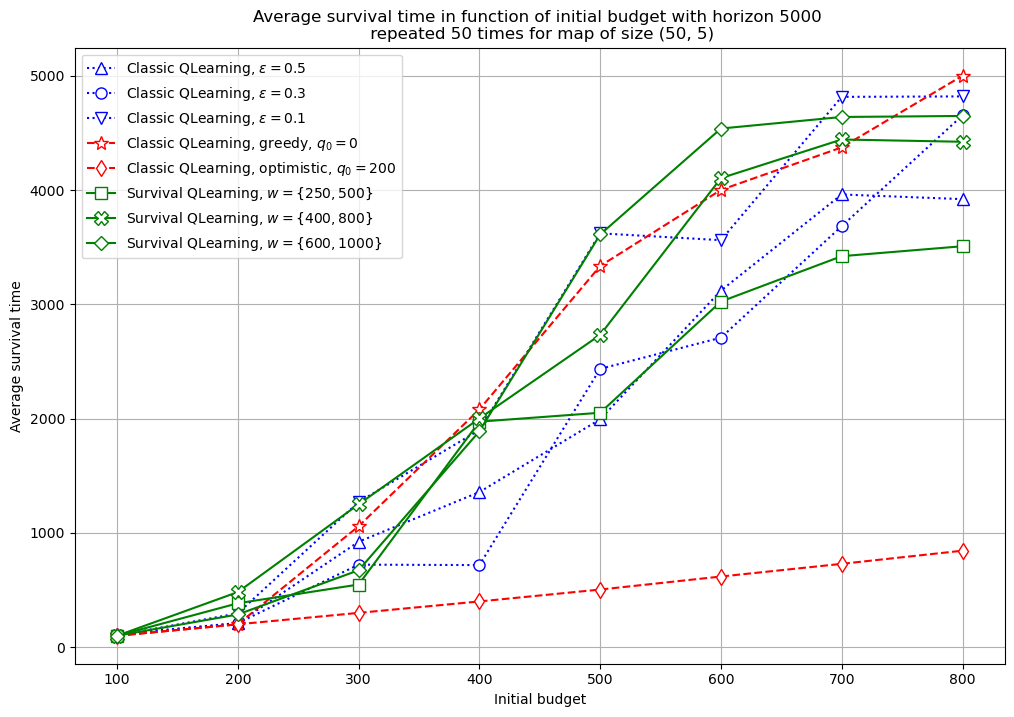

In [48]:
fig = plt.figure(figsize=(12, 8))
plt.plot(budgets, qclassic_5_time_mean, label=f"Classic QLearning, $\\varepsilon=0.5$", color='b', marker='^', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, qclassic_3_time_mean, label=f"Classic QLearning, $\\varepsilon=0.3$", color='b', marker='o', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, qclassic_1_time_mean, label=f"Classic QLearning, $\\varepsilon=0.1$", color='b', marker='v', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, qclassic_0_time_mean, label=f"Classic QLearning, greedy, $q_0=0$", color='r', ls='--', marker='*', markerfacecolor='w', markersize=10)
plt.plot(budgets, qclassic_h_time_mean, label=f"Classic QLearning, optimistic, $q_0=200$", color='r', ls='--', marker='d', markerfacecolor='w', markersize=8)
plt.plot(budgets, qsurvival_250_time_mean, label="Survival QLearning, $w = \\{250, 500\\}$", color='g', ls='-', marker='s', markerfacecolor='w', markersize=8)
plt.plot(budgets, qsurvival_400_time_mean, label="Survival QLearning, $w = \\{400, 800\\}$", color='g', ls='-', marker='X', markerfacecolor='w', markersize=10)
plt.plot(budgets, qsurvival_600_time_mean, label="Survival QLearning, $w = \\{600, 1000\\}$", color='g', ls='-', marker='D', markerfacecolor='w', markersize=7)
plt.xlabel("Initial budget")
plt.ylabel("Average survival time")
plt.legend()
plt.grid()
plt.title(f"Average survival time in function of initial budget with horizon {horizon} \n repeated {repeat} times for map of size {map_size}")  #and survival threshold [{survival_threshold}-{exploration_threshold}] 
plt.show()

### Alive rate

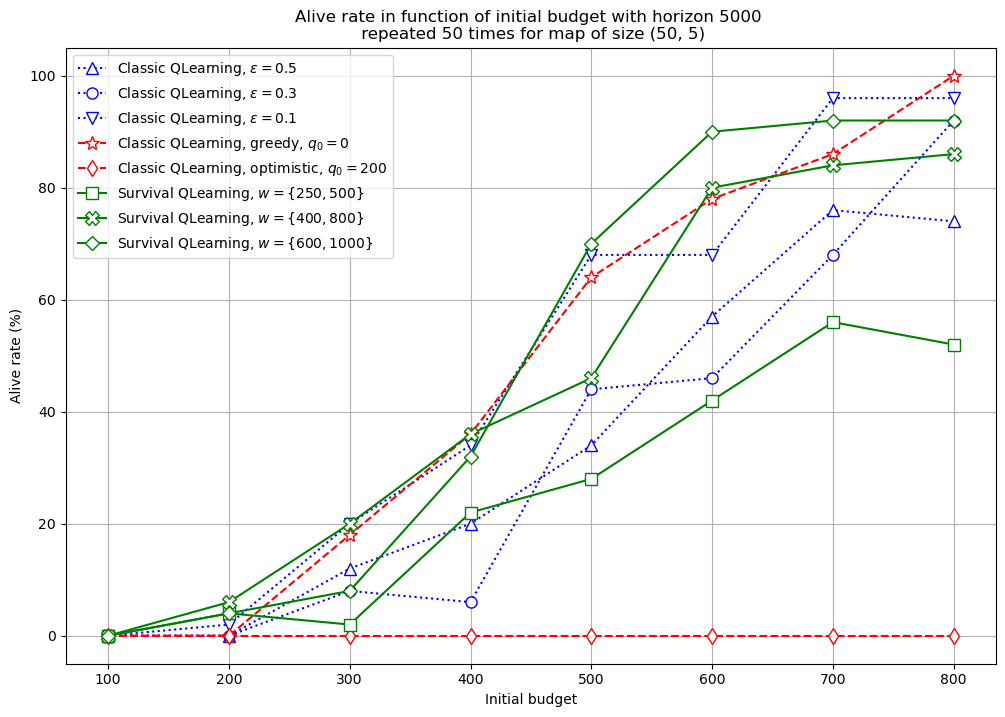

In [49]:
fig = plt.figure(figsize=(12, 8))
plt.plot(budgets, qclassic_5_alive_rate, label=f"Classic QLearning, $\\varepsilon=0.5$", color='b', marker='^', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, qclassic_3_alive_rate, label=f"Classic QLearning, $\\varepsilon=0.3$", color='b', marker='o', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, qclassic_1_alive_rate, label=f"Classic QLearning, $\\varepsilon=0.1$", color='b', marker='v', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, qclassic_0_alive_rate, label=f"Classic QLearning, greedy, $q_0=0$", color='r', ls='--', marker='*', markerfacecolor='w', markersize=10)
plt.plot(budgets, qclassic_h_alive_rate, label=f"Classic QLearning, optimistic, $q_0=200$", color='r', ls='--', marker='d', markerfacecolor='w', markersize=8)
plt.plot(budgets, qsurvival_250_alive_rate, label="Survival QLearning, $w = \\{250, 500\\}$", color='g', ls='-', marker='s', markerfacecolor='w', markersize=8)
plt.plot(budgets, qsurvival_400_alive_rate, label="Survival QLearning, $w = \\{400, 800\\}$", color='g', ls='-', marker='X', markerfacecolor='w', markersize=10)
plt.plot(budgets, qsurvival_600_alive_rate, label="Survival QLearning, $w = \\{600, 1000\\}$", color='g', ls='-', marker='D', markerfacecolor='w', markersize=7)
plt.xlabel("Initial budget")
plt.ylabel("Alive rate (%)")
plt.legend()
plt.grid()
plt.title(f"Alive rate in function of initial budget with horizon {horizon} \n repeated {repeat} times for map of size {map_size}")
plt.show()

### Exploration rate

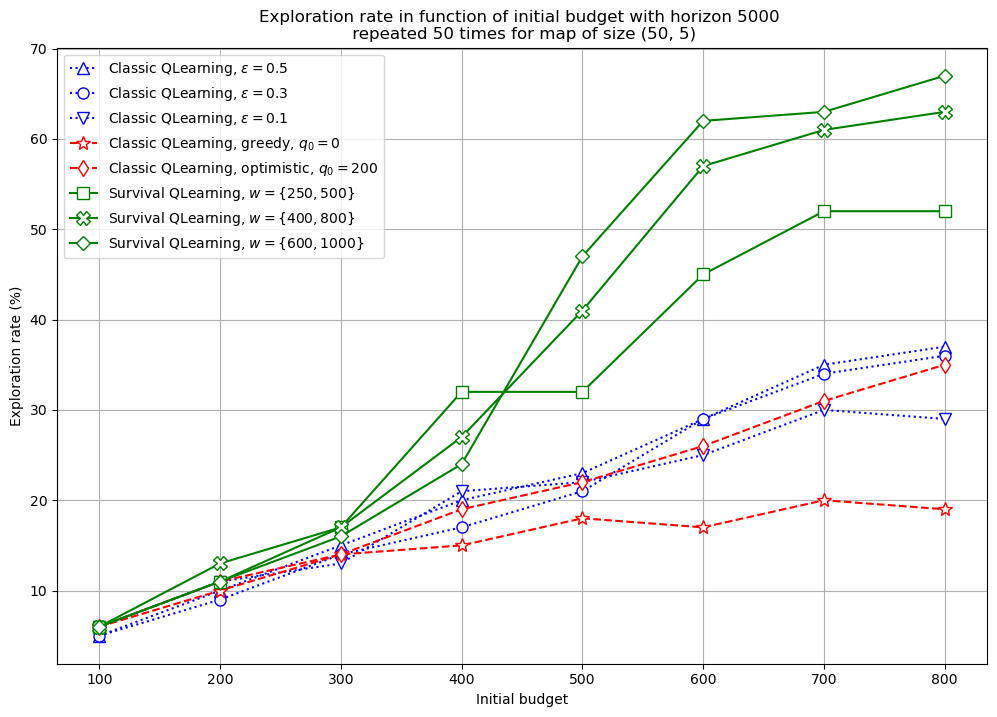

In [50]:
fig = plt.figure(figsize=(12, 8))
#plt.plot(budgets, cde_exploration_rate, label="CDELearning")
plt.plot(budgets, qclassic_5_exploration_rate, label=f"Classic QLearning, $\\varepsilon=0.5$", color='b', marker='^', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, qclassic_3_exploration_rate, label=f"Classic QLearning, $\\varepsilon=0.3$", color='b', marker='o', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, qclassic_1_exploration_rate, label=f"Classic QLearning, $\\varepsilon=0.1$", color='b', marker='v', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, qclassic_0_exploration_rate, label=f"Classic QLearning, greedy, $q_0=0$", color='r', ls='--', marker='*', markerfacecolor='w', markersize=10)
plt.plot(budgets, qclassic_h_exploration_rate, label=f"Classic QLearning, optimistic, $q_0=200$", color='r', ls='--', marker='d', markerfacecolor='w', markersize=8)
plt.plot(budgets, qsurvival_250_exploration_rate, label="Survival QLearning, $w = \\{250, 500\\}$", color='g', ls='-', marker='s', markerfacecolor='w', markersize=8)
plt.plot(budgets, qsurvival_400_exploration_rate, label="Survival QLearning, $w = \\{400, 800\\}$", color='g', ls='-', marker='X', markerfacecolor='w', markersize=10)
plt.plot(budgets, qsurvival_600_exploration_rate, label="Survival QLearning, $w = \\{600, 1000\\}$", color='g', ls='-', marker='D', markerfacecolor='w', markersize=7)
plt.xlabel("Initial budget")
plt.ylabel("Exploration rate (%)")
plt.legend()
plt.grid()
plt.title(f"Exploration rate in function of initial budget with horizon {horizon} \n repeated {repeat} times for map of size {map_size}")
plt.show()

### Budget evolution

In [51]:
print("Available budgets :")
print(budgets)

#plt.rcParams["figure.figsize"] = (10,10)

with_bounds = False

show_only = [300, 400, 500]
colors = ['r', 'g', 'b']


Available budgets :
[100 200 300 400 500 600 700 800]


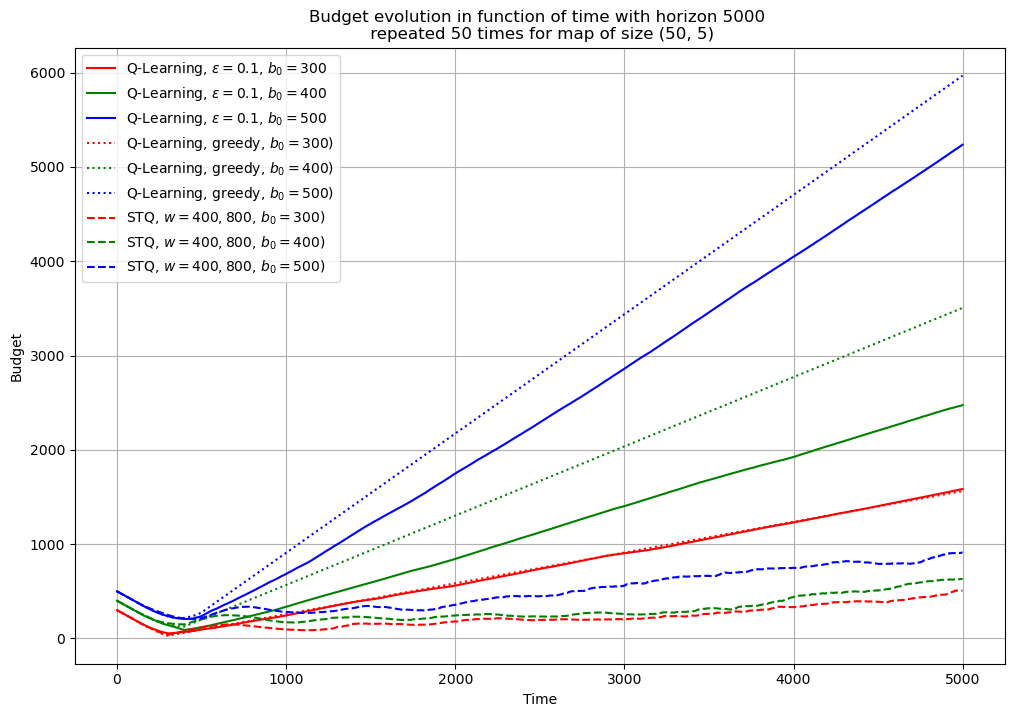

In [52]:
t = np.arange(horizon)

fig = plt.figure(figsize=(12, 8))

n=0
for i, evo in enumerate(qclassic_1_budget_evolutions_mean):
    if len(show_only) == 0 or budgets[i] in show_only:
        lines = plt.plot(t, evo, label=f"Q-Learning, $\\varepsilon=0.1$, $b_0=${budgets[i]}", ls='-', color=colors[n])
        n += 1
        if with_bounds:
            plt.fill_between(t, qclassic_1_budget_evolutions_min[i], qclassic_1__budget_evolutions_max[i], color=lines[0].get_color(), alpha=0.15)

n=0
for i, evo in enumerate(qclassic_0_budget_evolutions_mean):
    if len(show_only) == 0 or budgets[i] in show_only:
        lines = plt.plot(t, evo, label=f"Q-Learning, greedy, $b_0=${budgets[i]})", ls=':', color=colors[n])
        n += 1
        if with_bounds:
            plt.fill_between(t, qclassic_0_budget_evolutions_min[i], qclassic_0_budget_evolutions_max[i], color=lines[0].get_color(), alpha=0.15)
            
n=0
for i, evo in enumerate(qsurvival_400_budget_evolutions_mean):
    if len(show_only) == 0 or budgets[i] in show_only:
        lines = plt.plot(t, evo, label=f"STQ, $w={{400, 800}}$, $b_0=${budgets[i]})", ls='--', color=colors[n])
        n += 1
        if with_bounds:
            plt.fill_between(t, qsurvival_400_budget_evolutions_min[i], qsurvival_400_budget_evolutions_max[i], color=lines[0].get_color(), alpha=0.15)

#plt.yscale('symlog')

#plt.plot(t, np.full((horizon,), survival_threshold), color="magenta", label=f"Survival threshold {survival_threshold}", ls="-.")
#plt.plot(t, 4.5 * t, color="lawngreen", ls="--", label=f"Budget optimal minor")
#plt.plot(t, 49.5 * t, color="turquoise", ls="--", label=f"Budget optimal major")
plt.xlabel("Time")
plt.ylabel("Budget")
plt.legend()
plt.grid()
plt.title(f"Budget evolution in function of time with horizon {horizon} \n repeated {repeat} times for map of size {map_size}")
plt.show()